# Airborne magnetic survey of Afghanistan

https://ngdc.noaa.gov/geomag/aromag.shtml

License: [public domain](https://www.ngdc.noaa.gov/ngdcinfo/privacy.html#copyright-notice)

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import verde as vd
import pooch
import pyproj
import pygmt

## Download the data archive

Use Pooch to download the data archive and fetch the CSV file only (not the PDF reports included).

In [2]:
fname = pooch.retrieve(
    url="https://www.ngdc.noaa.gov/mgg/trk/aeromag/nrl_afghanistan/afghan_mag06a/afghan_mag06a.zip",
    known_hash="sha256:a5129bc3e0ad6e13c527c0115aef135508987712f371b19788fd3aef189470ee",
    # Unpack and return only the actual data, not the reports.
    processor=pooch.Unzip(members=["afghan_mag06a/data/mag88t/afghan_mag06a.m88t"]),
)[0]

In [3]:
print(f"{os.path.split(fname)[-1]}: {os.path.getsize(fname) / 1e6} Mb")

afghan_mag06a.m88t: 393.584462 Mb


## Read the data

Use pandas to load the CSV file. We'll convert the time and date into proper datetime objects. We'll also apply the diurnal correction and leave it at that since we will never be able to calculate it independently anyway.

In [4]:
data = pd.read_csv(
    fname, 
    sep="\t", 
    usecols=[1, 2, 3, 4, 5, 13, 22, 23], 
    header=0, 
    names="date time_seconds latitude longitude height_geometric_m magnetic_amplitude_nt diurnal_correction_nt igrf_nt".split(),
)
data["time_utc"] = pd.to_datetime(data.date, format="%Y%m%d") + pd.to_timedelta(np.round(data.time_seconds), unit="s")
data["magnetic_amplitude_nt"] -= data.diurnal_correction_nt
data.pop("date")
data.pop("time_seconds")
data.pop("diurnal_correction_nt")
data

latitude  longitude  height_geometric_m  magnetic_amplitude_nt  \
0        29.832119  64.867164             7924.82               46579.39   
1        29.832247  64.867067             7924.79               46579.62   
2        29.832375  64.866972             7924.76               46579.71   
3        29.832522  64.866861             7924.71               46579.77   
4        29.832650  64.866764             7924.66               46579.99   
...            ...        ...                 ...                    ...   
3664208  31.453192  67.390133             9284.80               47658.46   
3664209  31.453036  67.390227             9284.77               47658.40   
3664210  31.452901  67.390307             9284.75               47658.32   
3664211  31.452767  67.390388             9284.73               47658.23   
3664212  31.452633  67.390468             9284.71               47658.18   

          igrf_nt            time_utc  
0        46708.22 2006-06-25 06:53:23  
1        46708.27 2006-06-25 06:53:23  
2        46708.32 2006-06-25 06:53:23  
3        46708.38 2006-06-25 06:53:23  
4        46708.43 2006-06-25 06:53:23  
...           ...                 ...  
3664208  47767.08 2006-08-20 10:21:47  
3664209  47767.02 2006-08-20 10:21:47  
3664210  47766.96 2006-08-20 10:21:47  
3664211  47766.91 2006-08-20 10:21:48  
3664212  47766.86 2006-08-20 10:21:48  

[3664213 rows x 6 columns]

## Plot the data

Make a quick plot to make sure the data look OK. Block reduce the data a bit to avoid using up too much RAM and taking too long to plot.

In [5]:
data["total_field_anomaly_nt"] = data.magnetic_amplitude_nt - data.igrf_nt
region = vd.pad_region(vd.get_region((data.longitude, data.latitude)), 0.5)

In [6]:
blockmean = vd.BlockReduce(np.median, spacing=0.03)
(lon, lat), (mag, h) = blockmean.filter(
    (data.longitude, data.latitude), 
    (data.total_field_anomaly_nt, data.height_geometric_m),
)

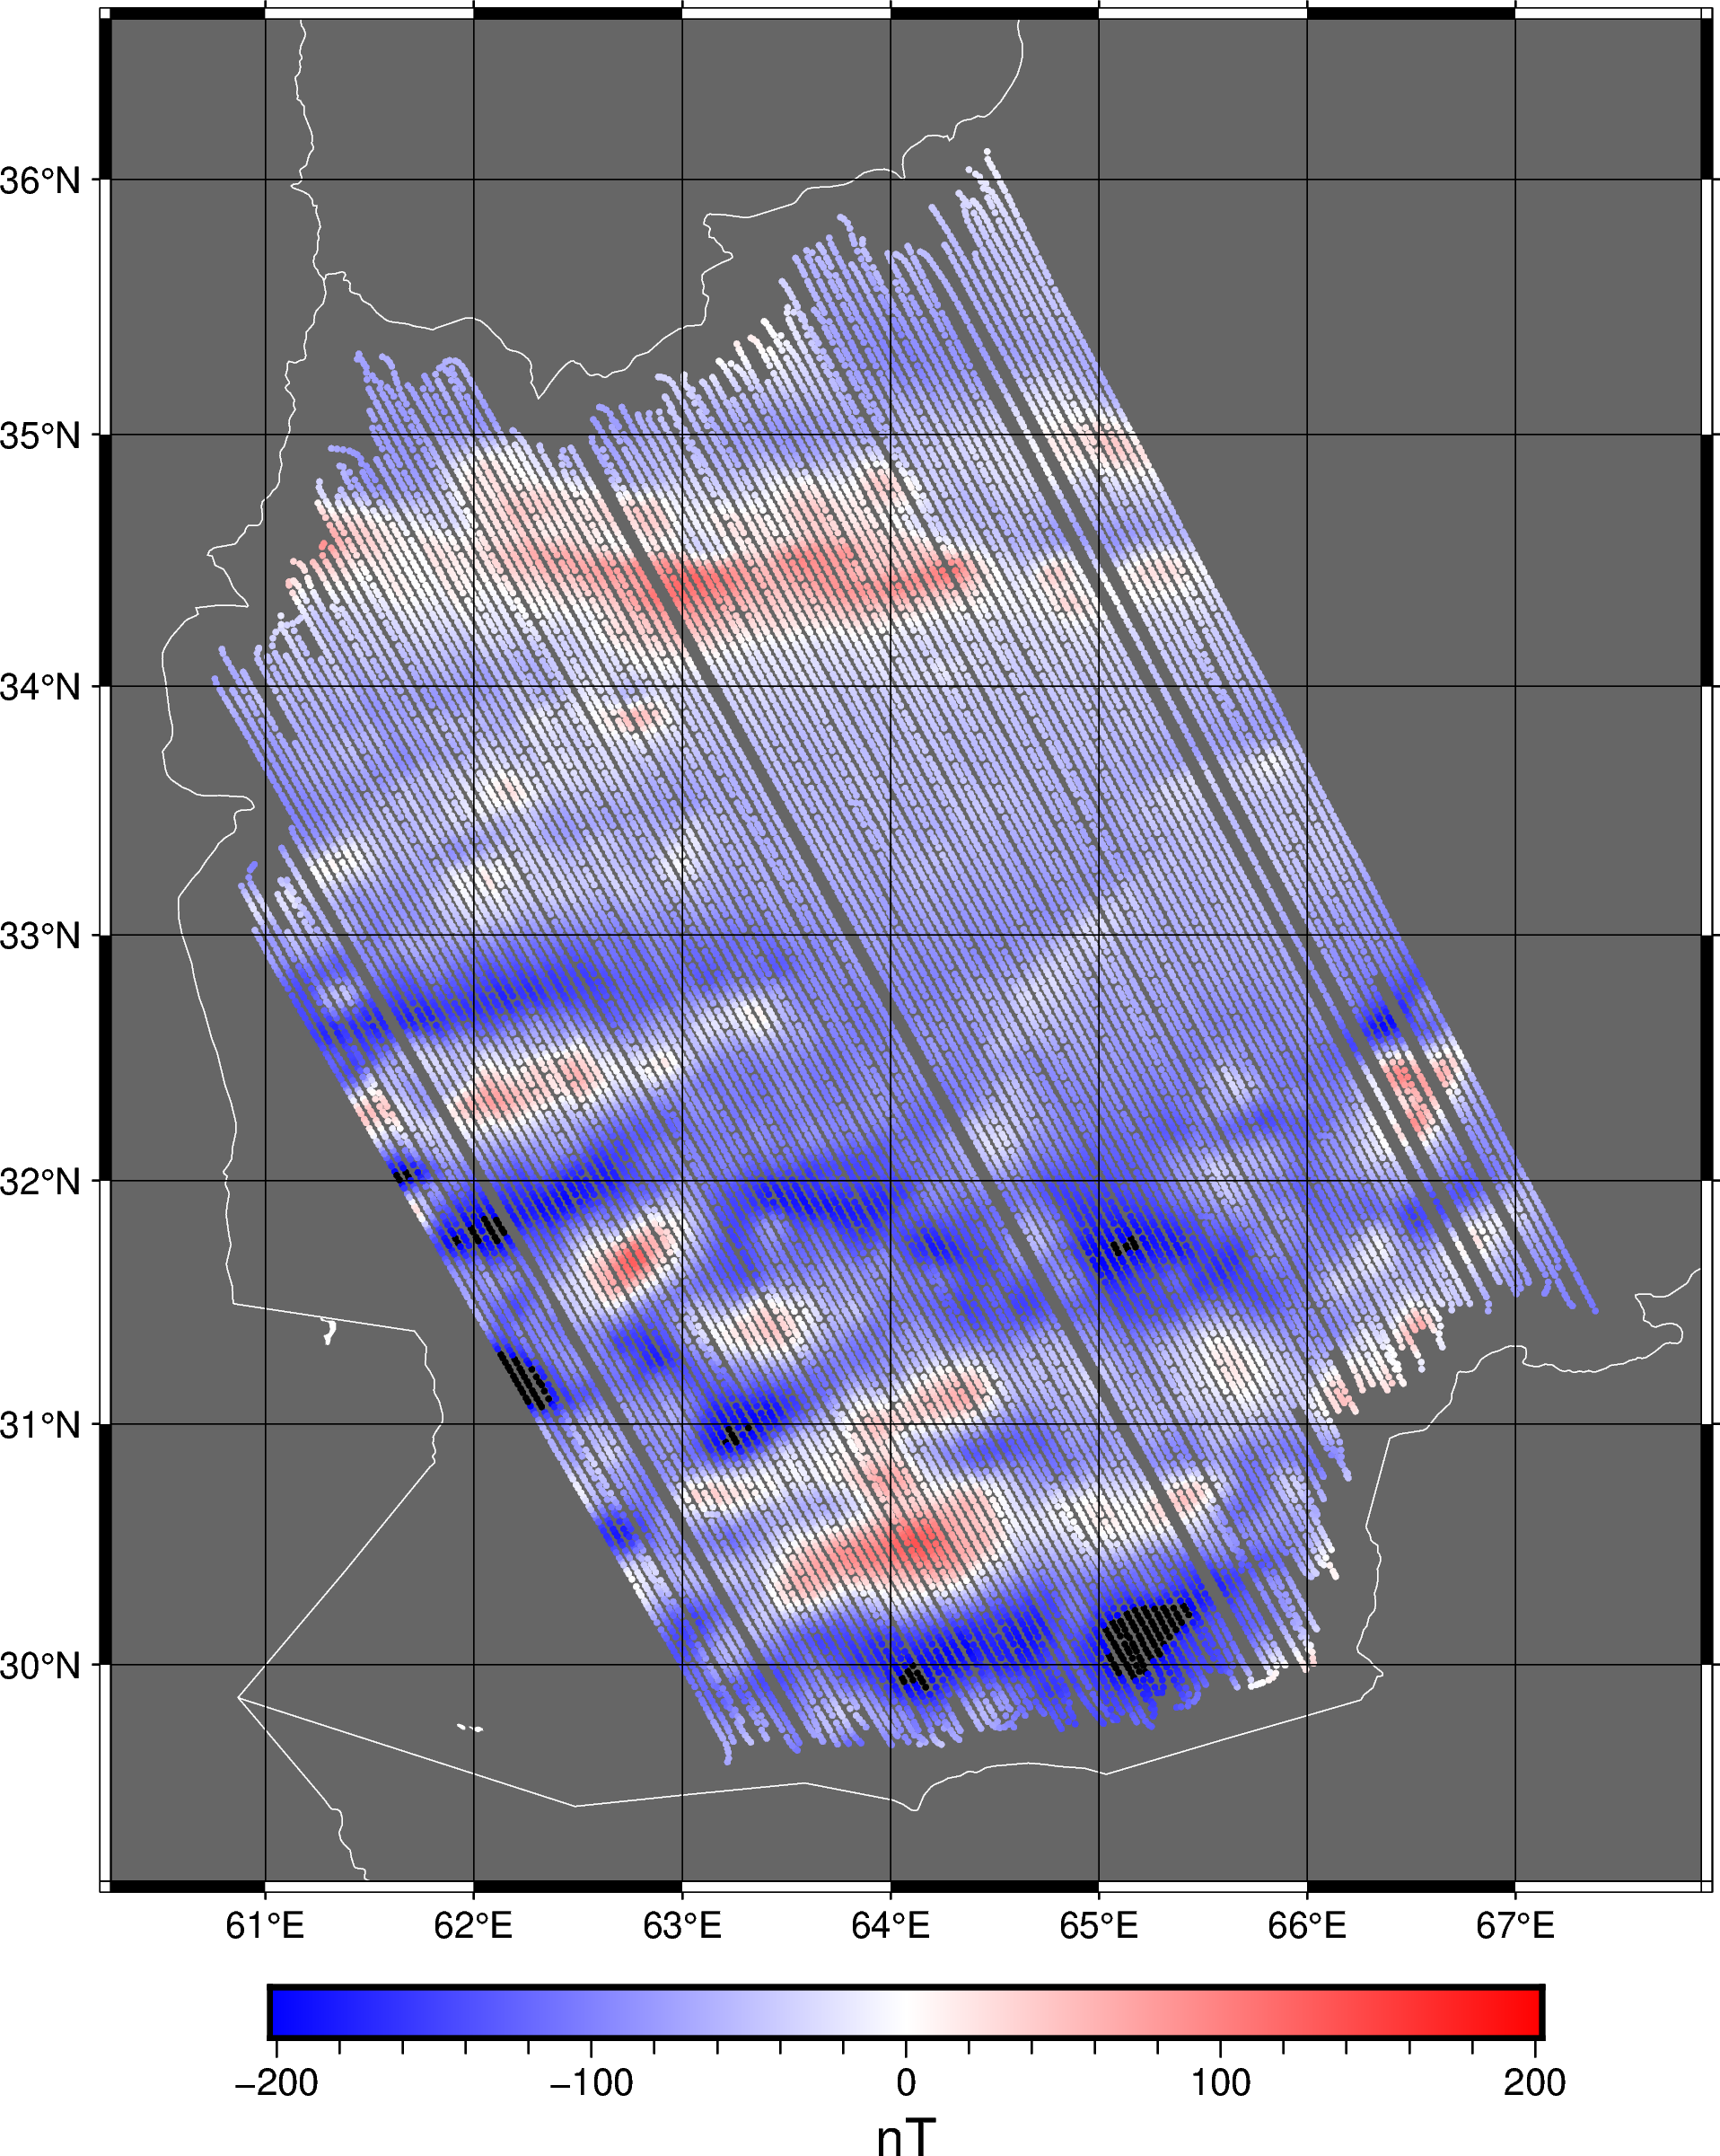

In [7]:
fig = pygmt.Figure()
fig.coast(region=region, projection="M15c", land="#666666", borders="1/white")
scale = 0.6 * vd.maxabs(data.total_field_anomaly_nt)
pygmt.makecpt(cmap="polar", series=[-scale, scale])
fig.plot(x=lon, y=lat, style="c0.06c", color=mag, cmap=True)
fig.colorbar(frame='af+l"nT"', position="JBC+o0/1c")
fig.basemap(frame="a1fg")
fig.show()

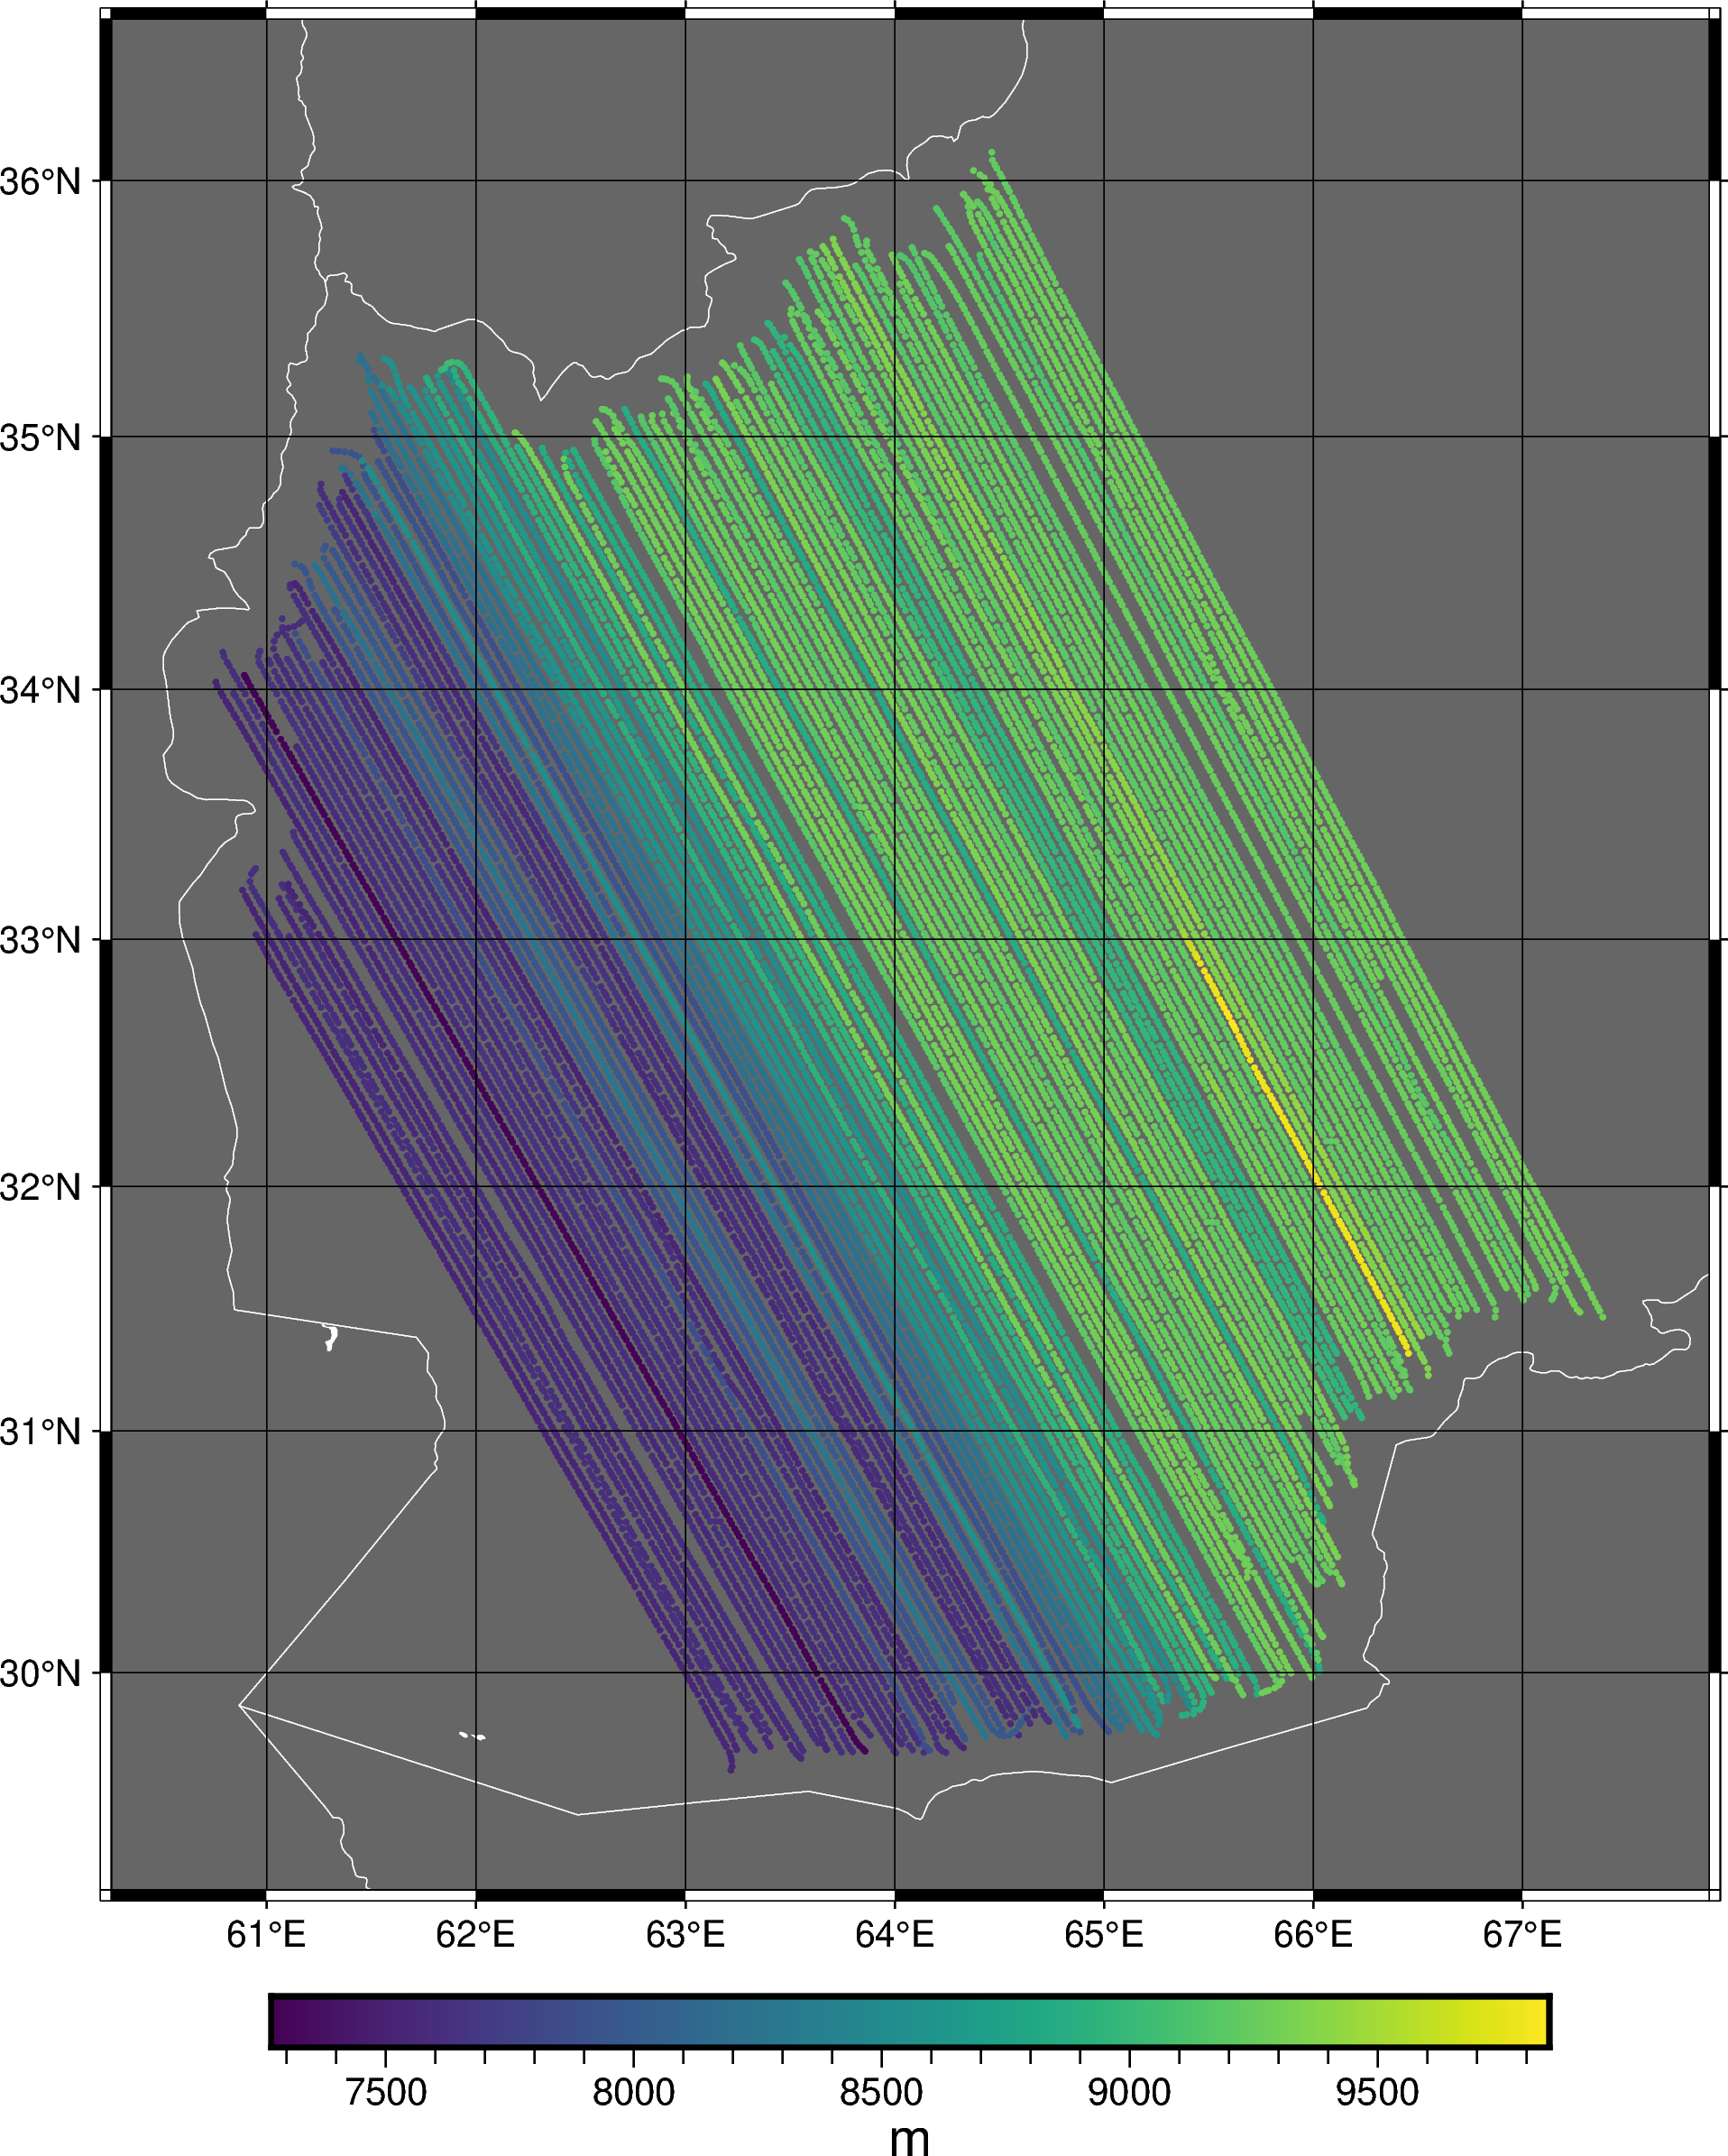

In [8]:
fig = pygmt.Figure()
fig.coast(region=region, projection="M15c", land="#666666", borders="1/white")
pygmt.makecpt(cmap="viridis", series=[h.min(), h.max()])
fig.plot(x=lon, y=lat, style="c0.06c", color=h, cmap=True)
fig.colorbar(frame='af+l"m"', position="JBC+o0/1c")
fig.basemap(frame="a1fg")
fig.show()

## Export

Make a separate DataFrame to export to CSV with only the chosen fields.

In [9]:
export = pd.DataFrame({  
    "time_utc": data.time_utc,  
    "longitude": data.longitude.map(lambda x: "{:.6f}".format(x)),
    "latitude": data.latitude.map(lambda x: "{:.6f}".format(x)),    
    "height_geometric_m": data.height_geometric_m.map(lambda x: "{:.1f}".format(x)),   
    "igrf_nt": data.igrf_nt.map(lambda x: "{:.1f}".format(x)),
    "magnetic_amplitude_nt": data.magnetic_amplitude_nt.map(lambda x: "{:.1f}".format(x)), 
})
export

time_utc  longitude   latitude height_geometric_m  igrf_nt  \
0       2006-06-25 06:53:23  64.867164  29.832119             7924.8  46708.2   
1       2006-06-25 06:53:23  64.867067  29.832247             7924.8  46708.3   
2       2006-06-25 06:53:23  64.866972  29.832375             7924.8  46708.3   
3       2006-06-25 06:53:23  64.866861  29.832522             7924.7  46708.4   
4       2006-06-25 06:53:23  64.866764  29.832650             7924.7  46708.4   
...                     ...        ...        ...                ...      ...   
3664208 2006-08-20 10:21:47  67.390133  31.453192             9284.8  47767.1   
3664209 2006-08-20 10:21:47  67.390227  31.453036             9284.8  47767.0   
3664210 2006-08-20 10:21:47  67.390307  31.452901             9284.8  47767.0   
3664211 2006-08-20 10:21:48  67.390388  31.452767             9284.7  47766.9   
3664212 2006-08-20 10:21:48  67.390468  31.452633             9284.7  47766.9   

        magnetic_amplitude_nt  
0                     46579.4  
1                     46579.6  
2                     46579.7  
3                     46579.8  
4                     46580.0  
...                       ...  
3664208               47658.5  
3664209               47658.4  
3664210               47658.3  
3664211               47658.2  
3664212               47658.2  

[3664213 rows x 6 columns]

In [10]:
fname = "afghanistan-magnetic.csv.xz"
export.to_csv(fname, index=False)
print(fname)
print(f"size: {os.path.getsize(fname) / 1e6} Mb")
for alg in ["md5", "sha256"]:
    print(f"{alg}:{pooch.file_hash(fname, alg=alg)}")

afghanistan-magnetic.csv.xz
size: 19.150192 Mb
md5:77baeefc2fc40049cb1f06d57ca2980a
sha256:2e4150c697546ee26c36c58a115d81c5102d383f3673195154749c2e138b0f26


## Read back the data and plot it

Verify that the output didn't corrupt anything.

In [15]:
mag = pd.read_csv(fname)
mag

time_utc  longitude   latitude  height_geometric_m  \
0        2006-06-25 06:53:23  64.867164  29.832119              7924.8   
1        2006-06-25 06:53:23  64.867067  29.832247              7924.8   
2        2006-06-25 06:53:23  64.866972  29.832375              7924.8   
3        2006-06-25 06:53:23  64.866861  29.832522              7924.7   
4        2006-06-25 06:53:23  64.866764  29.832650              7924.7   
...                      ...        ...        ...                 ...   
3664208  2006-08-20 10:21:47  67.390133  31.453192              9284.8   
3664209  2006-08-20 10:21:47  67.390227  31.453036              9284.8   
3664210  2006-08-20 10:21:47  67.390307  31.452901              9284.8   
3664211  2006-08-20 10:21:48  67.390388  31.452767              9284.7   
3664212  2006-08-20 10:21:48  67.390468  31.452633              9284.7   

         igrf_nt  magnetic_amplitude_nt  
0        46708.2                46579.4  
1        46708.3                46579.6  
2        46708.3                46579.7  
3        46708.4                46579.8  
4        46708.4                46580.0  
...          ...                    ...  
3664208  47767.1                47658.5  
3664209  47767.0                47658.4  
3664210  47767.0                47658.3  
3664211  47766.9                47658.2  
3664212  47766.9                47658.2  

[3664213 rows x 6 columns]

In [16]:
mag["total_field_anomaly_nt"] = mag.magnetic_amplitude_nt - mag.igrf_nt

In [17]:
(lon, lat), total_field = blockmean.filter(
    (mag.longitude, mag.latitude), 
    mag.total_field_anomaly_nt,
)

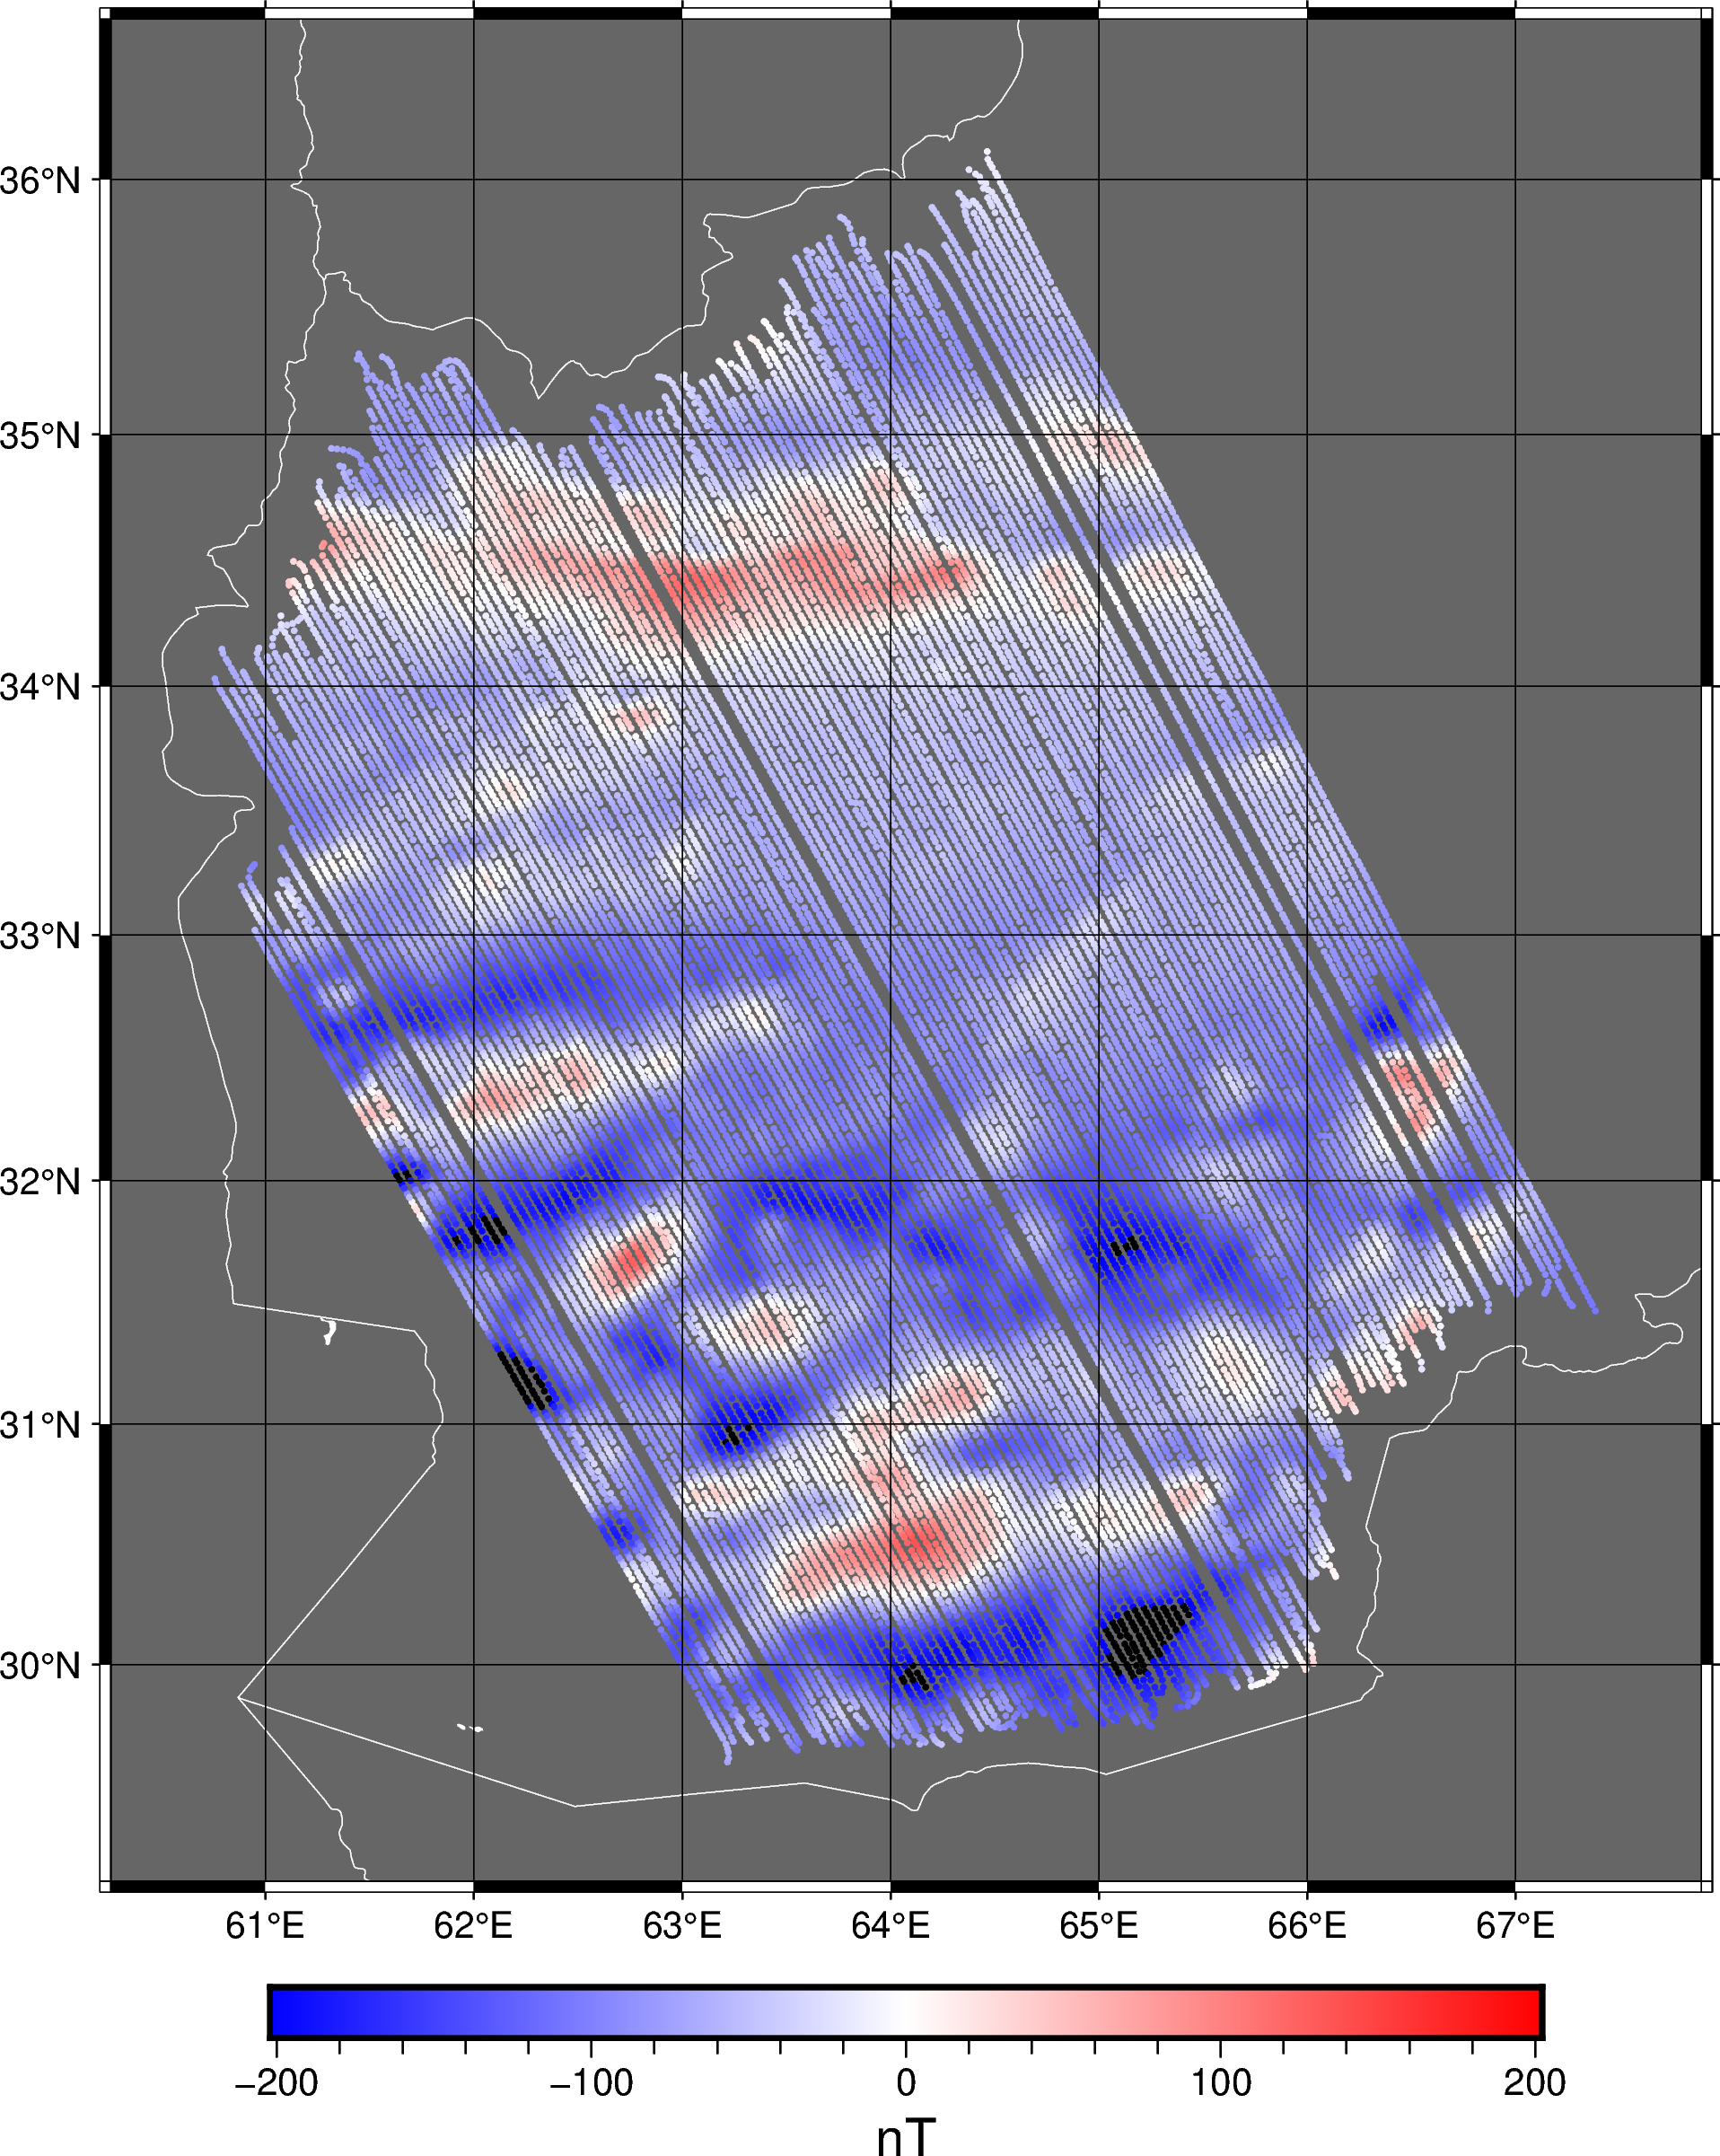

In [18]:
fig = pygmt.Figure()
fig.coast(region=region, projection="M15c", land="#666666", borders="1/white")
scale = 0.6 * vd.maxabs(mag.total_field_anomaly_nt)
pygmt.makecpt(cmap="polar", series=[-scale, scale])
fig.plot(x=lon, y=lat, style="c0.06c", color=total_field, cmap=True)
fig.colorbar(frame='af+l"nT"', position="JBC+o0/1c")
fig.basemap(frame="a1fg")
fig.show()